In [42]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

# Load dataset (replace 'path_to_your_dataset.csv' with the actual path)
data = pd.read_csv(r'D:\University of Rochester\Fall24\RA - Florian\Code\Li_Xie_2020_L1_vowels_statistics_general.csv')


In [44]:
# Define the range of sigma and noise_level values
sigma_values = np.linspace(0.5, 2.0, 10)       # Sigma from 0.1 to 2.0
noise_levels = np.linspace(0.02, 0.2, 10)       # Noise level from 0.1 to 0.6

# Prepare to store mean accuracies
mean_accuracies = np.zeros((len(sigma_values), len(noise_levels)))

# Add noise to features
def add_noise(features, noise_level):
    noisy_features = [f + np.random.normal(0, noise_level * f) for f in features]
    return noisy_features

# Compute similarity using Gaussian function
def compute_similarity(input_features, exemplar_features, sigma):
    dist = euclidean(input_features, exemplar_features)
    return np.exp(-dist**2 / (2 * sigma**2))

# Predict category based on exemplars
def predict_category(input_features, exemplars, sigma):
    category_similarities = {}
    total_similarity = 0

    # Calculate similarity for each category
    for category, ex_list in exemplars.items():
        category_sim_sum = sum(compute_similarity(input_features, exemplar, sigma) for exemplar in ex_list)
        category_similarities[category] = category_sim_sum
        total_similarity += category_sim_sum

    # Handle case when total_similarity is zero to avoid division by zero
    if total_similarity == 0:
        return None

    # Calculate posterior probabilities
    posteriors = {category: sim_sum / total_similarity for category, sim_sum in category_similarities.items()}

    # Return the category with the highest posterior probability
    return max(posteriors, key=posteriors.get)


In [45]:
# Loop over sigma and noise_level values
for i, sigma in enumerate(sigma_values):
    for j, noise_level in enumerate(noise_levels):
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        accuracy_scores = []

        # Main cross-validation loop
        for train_idx, test_idx in kfold.split(data):
            train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]

            # Train exemplars on the training set with added noise
            exemplars_train = defaultdict(list)
            for _, row in train_data.iterrows():
                category = row['Vowel']
                F0, F1, F2, duration = row['F0_gm'], row['F1_gm'], row['F2_gm'], row['Duration']
                noisy_features = add_noise([F0, F1, F2, duration], noise_level)
                if not np.any(np.isnan(noisy_features)) and not np.any(np.isinf(noisy_features)):
                    exemplars_train[category].append(noisy_features)

            # Predict on the test set
            predictions = []
            true_labels = []
            for _, row in test_data.iterrows():
                category = row['Vowel']
                input_features = [row['F0_gm'], row['F1_gm'], row['F2_gm'], row['Duration']]
                if not np.any(np.isnan(input_features)) and not np.any(np.isinf(input_features)):
                    predicted_category = predict_category(input_features, exemplars_train, sigma)
                    if predicted_category is not None:
                        predictions.append(predicted_category)
                        true_labels.append(category)

            # Calculate accuracy for this fold
            fold_accuracy = accuracy_score(true_labels, predictions)
            accuracy_scores.append(fold_accuracy)

        # Store mean accuracy for this combination
        mean_accuracy = np.mean(accuracy_scores)
        mean_accuracies[i, j] = mean_accuracy
        print(f"Sigma: {sigma:.2f}, Noise Level: {noise_level:.2f}, Mean Accuracy: {mean_accuracy:.4f}")


Sigma: 0.50, Noise Level: 0.02, Mean Accuracy: 0.9074
Sigma: 0.50, Noise Level: 0.04, Mean Accuracy: 0.8835
Sigma: 0.50, Noise Level: 0.06, Mean Accuracy: 0.8364
Sigma: 0.50, Noise Level: 0.08, Mean Accuracy: 0.7697
Sigma: 0.50, Noise Level: 0.10, Mean Accuracy: 0.7221
Sigma: 0.50, Noise Level: 0.12, Mean Accuracy: 0.6521
Sigma: 0.50, Noise Level: 0.14, Mean Accuracy: 0.6105
Sigma: 0.50, Noise Level: 0.16, Mean Accuracy: 0.5572
Sigma: 0.50, Noise Level: 0.18, Mean Accuracy: 0.4893
Sigma: 0.50, Noise Level: 0.20, Mean Accuracy: 0.4512
Sigma: 0.67, Noise Level: 0.02, Mean Accuracy: 0.9025
Sigma: 0.67, Noise Level: 0.04, Mean Accuracy: 0.8636
Sigma: 0.67, Noise Level: 0.06, Mean Accuracy: 0.8223
Sigma: 0.67, Noise Level: 0.08, Mean Accuracy: 0.7698
Sigma: 0.67, Noise Level: 0.10, Mean Accuracy: 0.7030
Sigma: 0.67, Noise Level: 0.12, Mean Accuracy: 0.6708
Sigma: 0.67, Noise Level: 0.14, Mean Accuracy: 0.6173
Sigma: 0.67, Noise Level: 0.16, Mean Accuracy: 0.5869
Sigma: 0.67, Noise Level: 0.

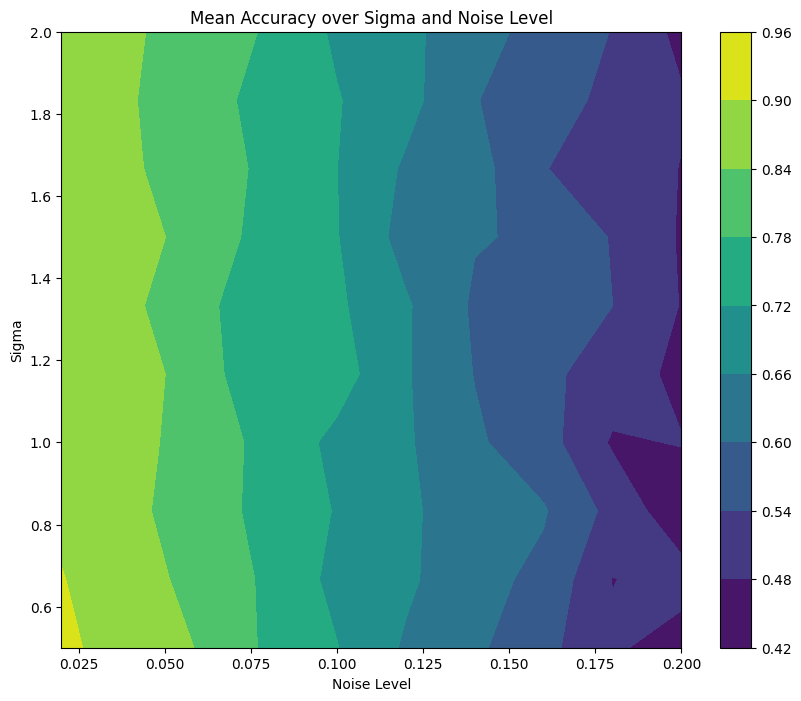

In [46]:
# Plotting the results
X, Y = np.meshgrid(noise_levels, sigma_values)
plt.figure(figsize=(10, 8))
cp = plt.contourf(X, Y, mean_accuracies, cmap='viridis')
plt.colorbar(cp)
plt.title('Mean Accuracy over Sigma and Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Sigma')
plt.show()

In [50]:
# Function to test the model on a new input
def test_model_on_new_input(new_input_features, exemplars_train, sigma):
    if np.any(np.isnan(new_input_features)) or np.any(np.isinf(new_input_features)):
        raise ValueError("Input features contain NaN or inf values")
    
    output_vector = predict_category(new_input_features, exemplars_train, sigma)
    return output_vector

# Example usage
new_input_features = [120, 500, 1500, 0.2]  # Replace with your actual input features
sigma = 1.0  # Use the same sigma value as used during training

# Assuming exemplars_train is already defined and trained
try:
    output_vector = test_model_on_new_input(new_input_features, exemplars_train, sigma)
    print("Output Vector (Posterior Probabilities):", output_vector)
except ValueError as e:
    print(e)

Output Vector (Posterior Probabilities): uh1


Sigma: 0.50, Noise Level: 0.02, Mean Log Likelihood: -322.3619, Criterion Acc: 0.8330, Luce Acc: 0.8330
Sigma: 0.50, Noise Level: 0.04, Mean Log Likelihood: -323.2923, Criterion Acc: 0.8193, Luce Acc: 0.8193
Sigma: 0.50, Noise Level: 0.06, Mean Log Likelihood: -428.7221, Criterion Acc: 0.7483, Luce Acc: 0.7483
Sigma: 0.50, Noise Level: 0.08, Mean Log Likelihood: -529.0782, Criterion Acc: 0.6715, Luce Acc: 0.6677
Sigma: 0.50, Noise Level: 0.10, Mean Log Likelihood: -597.8136, Criterion Acc: 0.5622, Luce Acc: 0.5622
Sigma: 0.50, Noise Level: 0.12, Mean Log Likelihood: -601.1844, Criterion Acc: 0.4769, Luce Acc: 0.4769
Sigma: 0.50, Noise Level: 0.14, Mean Log Likelihood: -626.3077, Criterion Acc: 0.4484, Luce Acc: 0.4484
Sigma: 0.50, Noise Level: 0.16, Mean Log Likelihood: -497.3584, Criterion Acc: 0.4614, Luce Acc: 0.4614
Sigma: 0.50, Noise Level: 0.18, Mean Log Likelihood: -512.7261, Criterion Acc: 0.3919, Luce Acc: 0.3919
Sigma: 0.50, Noise Level: 0.20, Mean Log Likelihood: -566.2292, 

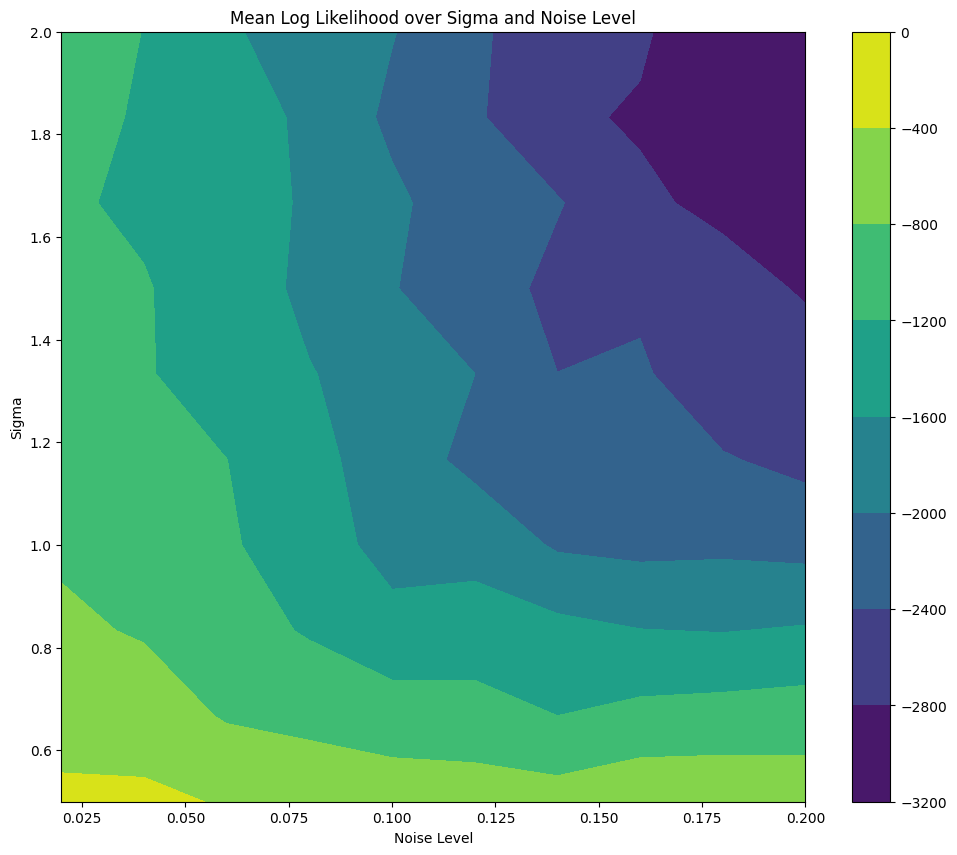

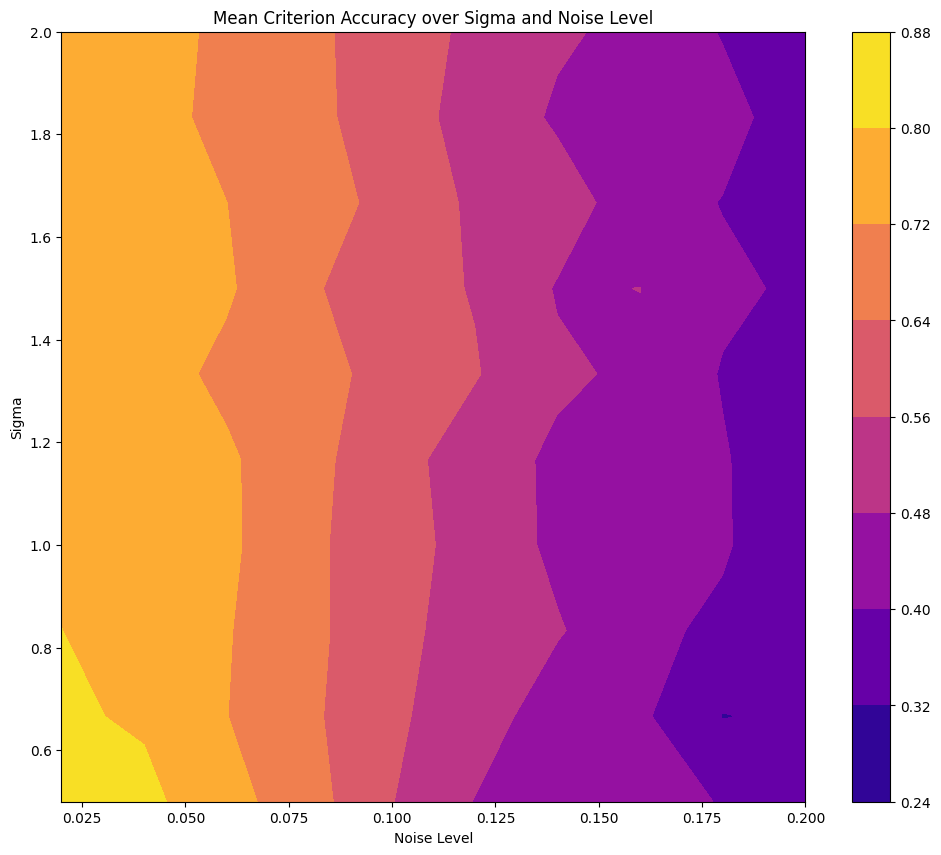

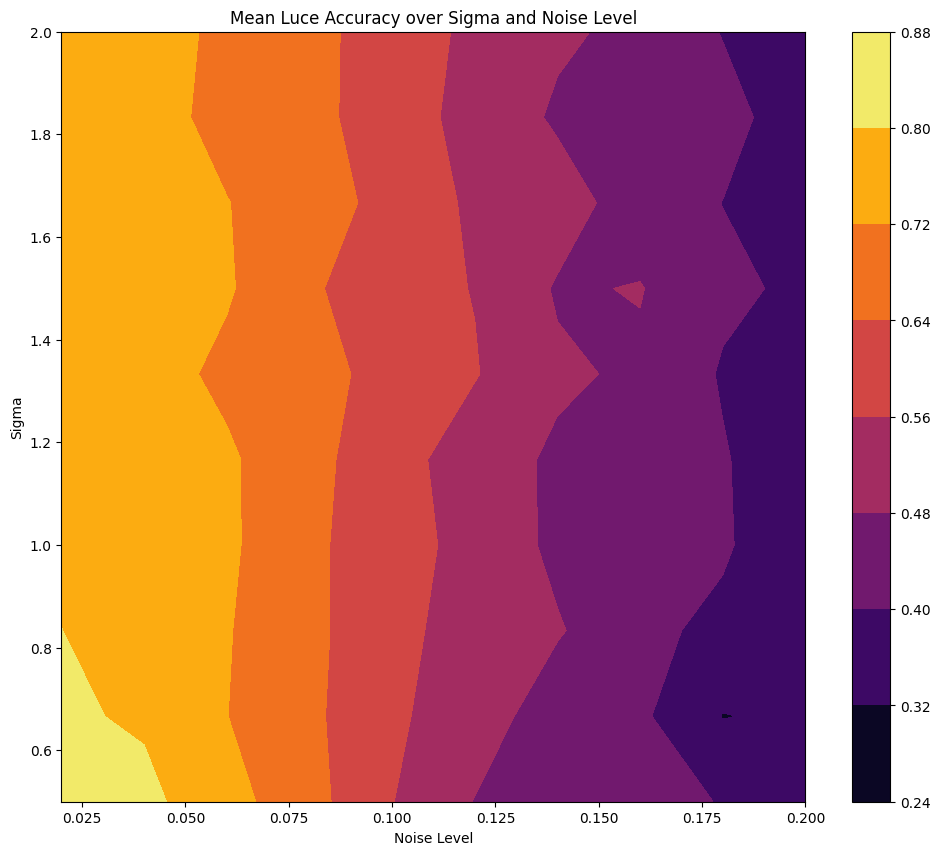

In [9]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, accuracy_score
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Load dataset
data = pd.read_csv(r'D:\University of Rochester\Fall24\RA - Florian\Code\Li_Xie_2020_L1_vowels_statistics_general.csv')

# Define sigma and noise_level ranges
sigma_values = np.linspace(0.5, 2.0, 10)
noise_levels = np.linspace(0.02, 0.2, 10)

# Initialize mean log likelihood storage
mean_log_likelihoods = np.zeros((len(sigma_values), len(noise_levels)))

# Free parameters for distance and similarity
distance_exponent = 2  # Exponent of the distance
feature_weights = np.array([1.0, 1.0, 1.0, 1.0])  # Weights for F0, F1, F2, Duration
similarity_scaling = 1.0  # Scaling factor for similarity

# Add noise to features
def add_noise(features, noise_level):
    return [f + np.random.normal(0, noise_level * f) for f in features]

# Compute weighted Euclidean distance with exponent
def compute_distance(input_features, exemplar_features, weights, exponent):
    weighted_diff = weights * (np.array(input_features) - np.array(exemplar_features))
    distance = np.sum(np.abs(weighted_diff) ** exponent) ** (1/exponent)
    return distance

# Compute similarity using Gaussian function with scaling factor
def compute_similarity(input_features, exemplar_features, weights, exponent, scaling, sigma):
    dist = compute_distance(input_features, exemplar_features, weights, exponent)
    return np.exp(- (scaling * dist) ** 2 / (2 * sigma ** 2))

# Predict posterior probabilities based on exemplars
def predict_posterior(input_features, exemplars, weights, exponent, scaling, sigma, prior):
    category_similarities = {}
    total_similarity = 0
    for category, ex_list in exemplars.items():
        sim_sum = sum(compute_similarity(input_features, ex, weights, exponent, scaling, sigma) for ex in ex_list)
        category_similarities[category] = sim_sum
        total_similarity += sim_sum
    if total_similarity == 0:
        return None
    # Apply prior
    posteriors = {cat: (sim_sum * prior.get(cat, 1.0)) for cat, sim_sum in category_similarities.items()}
    total_posterior = sum(posteriors.values())
    # Avoid division by zero
    if total_posterior == 0:
        return None
    posteriors = {cat: (sim / total_posterior) for cat, sim in posteriors.items()}
    return posteriors

# Cross-validation setup
group_kfold = GroupKFold(n_splits=5)  # Reduced from 17 to 5 for better fold sizes
groups = data['Talker']

# Define uniform prior
unique_categories = sorted(data['Vowel'].unique())
prior = {cat: 1.0 for cat in unique_categories}  # Uniform prior

# Function to calculate accuracy using criterion rule
def calculate_criterion_accuracy(true_labels, preds):
    correct = 0
    for true, pred in zip(true_labels, preds):
        predicted = max(pred, key=pred.get)
        if predicted == true:
            correct += 1
    return correct / len(true_labels) if true_labels else 0

# Function to calculate accuracy using Luce's choice rule
def calculate_luce_accuracy(true_labels, preds):
    correct = 0
    for true, pred in zip(true_labels, preds):
        probabilities = np.array([pred.get(cat, 0) for cat in unique_categories])
        probabilities = probabilities / probabilities.sum() if probabilities.sum() > 0 else probabilities
        # To handle cases where probabilities sum to zero
        if probabilities.sum() == 0:
            continue
        choice = np.random.choice(unique_categories, p=probabilities)
        if choice == true:
            correct += 1
    return correct / len(true_labels) if true_labels else 0

# Function to calculate log likelihood for a single prediction
def calculate_log_likelihood(true_label, posterior, classes):
    if posterior is None:
        return 0
    prob = posterior.get(true_label, 1e-10)
    # Ensure probability is not zero or negative
    prob = max(prob, 1e-10)
    return np.log(prob)

# Function to perform cross-validation and evaluate the model
def evaluate_model(data, sigma_values, noise_levels, group_kfold, groups, weights, exponent, scaling, prior, resamples=100):
    mean_log_likelihoods = np.zeros((len(sigma_values), len(noise_levels)))
    mean_criterion_accuracies = np.zeros((len(sigma_values), len(noise_levels)))
    mean_luce_accuracies = np.zeros((len(sigma_values), len(noise_levels)))
    
    for i, sigma in enumerate(sigma_values):
        for j, noise_level in enumerate(noise_levels):
            log_likelihoods = []
            criterion_accuracies = []
            luce_accuracies = []
            
            for train_idx, test_idx in group_kfold.split(data, groups=groups):
                train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
                exemplars_train = defaultdict(list)
                
                # Train exemplars with added noise
                for _, row in train_data.iterrows():
                    category = row['Vowel']
                    features = [row['F0_gm'], row['F1_gm'], row['F2_gm'], row['Duration']]
                    noisy = add_noise(features, noise_level)
                    if not np.any(np.isnan(noisy)) and not np.any(np.isinf(noisy)):
                        exemplars_train[category].append(noisy)
                
                true_labels = []
                preds_posteriors = []
                
                # Predict on test set
                for _, row in test_data.iterrows():
                    true = row['Vowel']
                    input_feat = [row['F0_gm'], row['F1_gm'], row['F2_gm'], row['Duration']]
                    noisy_input = add_noise(input_feat, noise_level)
                    if not np.any(np.isnan(noisy_input)) and not np.any(np.isinf(noisy_input)):
                        posteriors = predict_posterior(noisy_input, exemplars_train, weights, exponent, scaling, sigma, prior)
                        if posteriors:
                            preds_posteriors.append(posteriors)
                            true_labels.append(true)
                
                if true_labels:
                    # Calculate log likelihood
                    fold_log_likelihood = sum([calculate_log_likelihood(t, p, unique_categories) for t, p in zip(true_labels, preds_posteriors)])
                    log_likelihoods.append(fold_log_likelihood)
                    
                    # Calculate accuracies
                    criterion_acc = calculate_criterion_accuracy(true_labels, preds_posteriors)
                    luce_acc = calculate_luce_accuracy(true_labels, preds_posteriors)
                    criterion_accuracies.append(criterion_acc)
                    luce_accuracies.append(luce_acc)
            
            # Aggregate results
            if log_likelihoods:
                mean_ll = np.mean(log_likelihoods)
                mean_log_likelihoods[i, j] = mean_ll
            else:
                mean_log_likelihoods[i, j] = np.nan
            
            if criterion_accuracies:
                mean_criterion_accuracies[i, j] = np.mean(criterion_accuracies)
            else:
                mean_criterion_accuracies[i, j] = np.nan
            
            if luce_accuracies:
                mean_luce_accuracies[i, j] = np.mean(luce_accuracies)
            else:
                mean_luce_accuracies[i, j] = np.nan
            
            print(f"Sigma: {sigma:.2f}, Noise Level: {noise_level:.2f}, Mean Log Likelihood: {mean_log_likelihoods[i, j]:.4f}, Criterion Acc: {mean_criterion_accuracies[i, j]:.4f}, Luce Acc: {mean_luce_accuracies[i, j]:.4f}")
    
    return mean_log_likelihoods, mean_criterion_accuracies, mean_luce_accuracies

# Evaluate the model
mean_log_likelihoods, mean_criterion_accuracies, mean_luce_accuracies = evaluate_model(
    data, sigma_values, noise_levels, group_kfold, groups, feature_weights, distance_exponent, similarity_scaling, prior
)

# Visualize Mean Log Likelihood
X, Y = np.meshgrid(noise_levels, sigma_values)
plt.figure(figsize=(12, 10))
cp = plt.contourf(X, Y, mean_log_likelihoods, cmap='viridis')
plt.colorbar(cp)
plt.title('Mean Log Likelihood over Sigma and Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Sigma')
plt.show()

# Visualize Criterion Accuracy
plt.figure(figsize=(12, 10))
cp = plt.contourf(X, Y, mean_criterion_accuracies, cmap='plasma')
plt.colorbar(cp)
plt.title('Mean Criterion Accuracy over Sigma and Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Sigma')
plt.show()

# Visualize Luce Accuracy
plt.figure(figsize=(12, 10))
cp = plt.contourf(X, Y, mean_luce_accuracies, cmap='inferno')
plt.colorbar(cp)
plt.title('Mean Luce Accuracy over Sigma and Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Sigma')
plt.show()

In [6]:
data = pd.read_csv(r'D:\University of Rochester\Fall24\RA - Florian\Code\Li_Xie_2020_L1_vowels_statistics_general.csv')
set(data['Talker'].values)

{'E1',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E15',
 'E16',
 'E17',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9'}

In [ ]:
# Function to test the model on a new input
def test_model_on_new_input(new_input_features, exemplars_train, sigma, noise_level):
    noisy_input = add_noise(new_input_features, noise_level)
    if np.any(np.isnan(noisy_input)) or np.any(np.isinf(noisy_input)):
        raise ValueError("Input features contain NaN or inf values")
    posteriors = predict_category(noisy_input, exemplars_train, sigma)
    return posteriors

# Example usage
new_input_features = [120, 500, 1500, 0.2]
sigma = 1.0
noise_level = 0.05

try:
    output_vector = test_model_on_new_input(new_input_features, exemplars_train, sigma, noise_level)
    print("Output Vector (Posterior Probabilities):", output_vector)
except ValueError as e:
    print(e)